In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath
import re
import numpy as np
import nltk
import itertools
# nltk.download()
from nltk.corpus import stopwords
from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2
#!pip install python-Levenshtein

# Исходные данные

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [5]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/home/arthur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 17.8 s, sys: 861 ms, total: 18.7 s
Wall time: 18.7 s


In [8]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 2min 17s, sys: 52.9 ms, total: 2min 18s
Wall time: 2min 18s


А теперь в 3 строчки обучим нашу модель

In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [10]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [11]:
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [12]:
%%time
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']
CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 1.22 ms


[(1, 0.22837557),
 (7, 0.028706087),
 (17, 0.25667158),
 (18, 0.031164134),
 (20, 0.4341134)]

In [13]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: украина украинский убийство nn россия белоруссия глава
topic_1: ракета nn первый всё сша станция эксперт
topic_2: россия сша российский ребёнок экономика новый американский
topic_3: россия военный российский наука научный nn министр
topic_4: область проект статья журнал смерть управление nn
topic_5: университет продукция земля спрос товар космос ступень
topic_6: пациент испытание наиболее вероятно турецкий курс турция
topic_7: рост объём доход млрд доллар вырасти уровень
topic_8: всё россия произойти данные выяснить район помощь
topic_9: банк гражданин nn рф сотрудник источник российский
topic_10: nn всё жизнь рынок новый участник пенсия
topic_11: обнаружить земля двигатель топливо конкурс скорость час
topic_12: вода восток экипаж бомба оборудование производить лодка
topic_13: рубль млрд средство федеральный законодательство торговый размер
topic_14: мышь сон саммит диск осипов калинин браун
topic_15: газ фестиваль километр высота сектор небо метан
topic_16: исследование совет

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [14]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [15]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

CPU times: user 45.9 s, sys: 528 ms, total: 46.5 s
Wall time: 16.6 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.073412,0.084757,0.0,0.000000,0.0,0.000000,0.000000,0.0
1,4896,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.207531,0.000000,0.0,0.031690,0.0,0.068141,0.000000,0.0
2,4897,0.0,0.228422,0.000000,0.0,0.0,0.0,0.0,0.028696,0.000000,...,0.0,0.000000,0.256665,0.031164,0.0,0.434083,0.0,0.000000,0.000000,0.0
3,4898,0.0,0.711455,0.000000,0.0,0.0,0.0,0.0,0.000000,0.165312,...,0.0,0.000000,0.112136,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,4899,0.0,0.000000,0.218206,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.246103,0.000000,0.000000,0.0,0.108418,0.0,0.000000,0.027326,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [16]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [17]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [18]:
doc_dict[293622]

array([0.        , 0.1208531 , 0.20056346, 0.07074524, 0.        ,
       0.        , 0.0399852 , 0.        , 0.07426506, 0.11299194,
       0.22509237, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1439521 , 0.        , 0.        , 0.        ])

In [19]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [20]:
get_user_embedding(user_articles_list)

array([0.1283705 , 0.07290765, 0.23953629, 0.13717223, 0.01687646,
       0.03003152, 0.02238   , 0.02802211, 0.05771789, 0.09572567,
       0.03353093, 0.        , 0.00170391, 0.        , 0.        ,
       0.        , 0.01411728, 0.        , 0.00186087, 0.04837229,
       0.        , 0.01716373, 0.0232449 , 0.01758851, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [21]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [22]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [23]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.139286,0.109497,0.101148,0.023338,0.089878,0.064057,0.066503,0.000000,0.068096,...,0.00000,0.003514,0.013140,0.000000,0.000000,0.060418,0.023992,0.007259,0.000000,0.045304
1,u108690,0.117323,0.121217,0.111736,0.086048,0.024764,0.007343,0.016590,0.006711,0.158120,...,0.00000,0.008588,0.000000,0.010440,0.013125,0.006721,0.010610,0.004327,0.005817,0.036151
2,u108339,0.088223,0.069471,0.103071,0.098152,0.078329,0.007255,0.034608,0.000000,0.195842,...,0.00569,0.015324,0.003745,0.027593,0.014448,0.000000,0.007753,0.016946,0.015286,0.018312


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [24]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [25]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.139286,0.109497,0.101148,0.023338,0.089878,0.064057,0.066503,0.000000,0.068096,...,0.003514,0.013140,0.000000,0.000000,0.060418,0.023992,0.007259,0.000000,0.045304,0
1,u108690,0.117323,0.121217,0.111736,0.086048,0.024764,0.007343,0.016590,0.006711,0.158120,...,0.008588,0.000000,0.010440,0.013125,0.006721,0.010610,0.004327,0.005817,0.036151,1
2,u108339,0.088223,0.069471,0.103071,0.098152,0.078329,0.007255,0.034608,0.000000,0.195842,...,0.015324,0.003745,0.027593,0.014448,0.000000,0.007753,0.016946,0.015286,0.018312,1


In [26]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [27]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08107211, 0.02804999, 0.46256468, 0.31608721, 0.09004429,
       0.05407077, 0.04201286, 0.06199991, 0.1429079 , 0.0644207 ])

### Рассчитаем Precision, Recall, F_score

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.257710, F-Score=0.710, Precision=0.626, Recall=0.820


In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1635  120]
 [  45  200]]


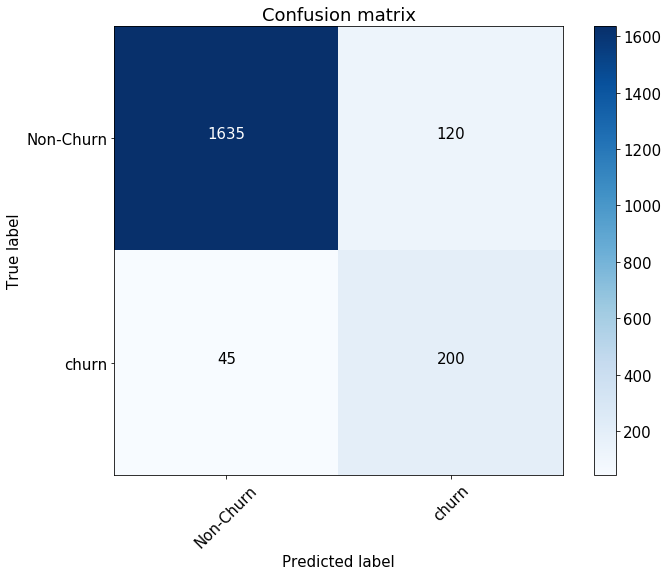

In [31]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [32]:
roc_auc_score(y_test, preds)

0.9599813942671085

In [33]:
roc_auc_mean, precision_mean, recall_mean = roc_auc_score(y_test, preds), precision, recall
f_score_mean = 2 * (precision * recall) / (precision + recall)

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

***
***
***

# 1. Модифицировать код функции get_user_embedding
* Модифицировать таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана.  
* Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их:  
roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [34]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [35]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.023180,0.093907,0.044332,0.000000,0.037435,0.00981,0.019993,0.0,0.036445,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,u108690,0.103486,0.129114,0.115121,0.059560,0.012692,0.00000,0.000000,0.0,0.133857,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,u108339,0.092254,0.038829,0.091679,0.053187,0.060051,0.00000,0.029379,0.0,0.205020,...,0.0,0.0,0.0,0.009926,0.0,0.0,0.0,0.013904,0.006914,0.006472


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [36]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [37]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.023180,0.093907,0.044332,0.000000,0.037435,0.00981,0.019993,0.0,0.036445,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
1,u108690,0.103486,0.129114,0.115121,0.059560,0.012692,0.00000,0.000000,0.0,0.133857,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1
2,u108339,0.092254,0.038829,0.091679,0.053187,0.060051,0.00000,0.029379,0.0,0.205020,...,0.0,0.0,0.009926,0.0,0.0,0.0,0.013904,0.006914,0.006472,1


In [38]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [39]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.03463308, 0.05015321, 0.65363187, 0.26225457, 0.01081966,
       0.02527957, 0.02613004, 0.04630613, 0.38450757, 0.07561479])

### Рассчитаем Precision, Recall, F_score

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.283152, F-Score=0.790, Precision=0.705, Recall=0.898


In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1663   92]
 [  26  219]]


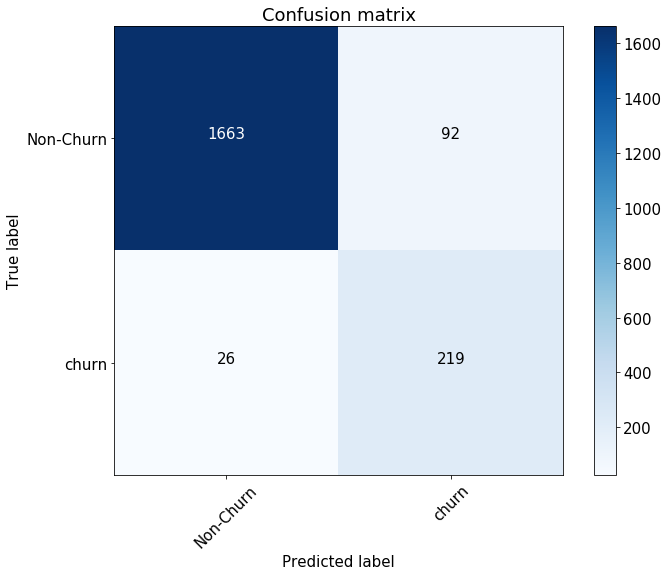

In [43]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [44]:
roc_auc_score(y_test, preds)

0.979852316995174

In [45]:
roc_auc_median, precision_median, recall_median = roc_auc_score(y_test, preds), precision, recall
f_score_median = 2 * (precision * recall) / (precision + recall)

# 2. Повторить п.1, но используя уже не медиану, а max

In [46]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [47]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.530315,0.248979,0.317659,0.070745,0.384065,0.186147,0.213782,0.000000,0.261422,...,0.000000,0.021087,0.078839,0.000000,0.000000,0.255880,0.143952,0.030537,0.000000,0.170064
1,u108690,0.249901,0.244307,0.225100,0.200359,0.070232,0.028135,0.085427,0.040264,0.361641,...,0.000000,0.035976,0.000000,0.039141,0.043158,0.022939,0.047662,0.025961,0.034900,0.184126
2,u108339,0.180263,0.176204,0.246337,0.271612,0.190562,0.033385,0.097750,0.000000,0.378770,...,0.034141,0.069784,0.022473,0.104540,0.062169,0.000000,0.046516,0.039930,0.063367,0.064743


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [48]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [49]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.530315,0.248979,0.317659,0.070745,0.384065,0.186147,0.213782,0.000000,0.261422,...,0.021087,0.078839,0.000000,0.000000,0.255880,0.143952,0.030537,0.000000,0.170064,0
1,u108690,0.249901,0.244307,0.225100,0.200359,0.070232,0.028135,0.085427,0.040264,0.361641,...,0.035976,0.000000,0.039141,0.043158,0.022939,0.047662,0.025961,0.034900,0.184126,1
2,u108339,0.180263,0.176204,0.246337,0.271612,0.190562,0.033385,0.097750,0.000000,0.378770,...,0.069784,0.022473,0.104540,0.062169,0.000000,0.046516,0.039930,0.063367,0.064743,1


In [50]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [51]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07567775, 0.0048023 , 0.71883516, 0.1146698 , 0.00152962,
       0.00503985, 0.0480761 , 0.05774414, 0.0295189 , 0.1428813 ])

### Рассчитаем Precision, Recall, F_score

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.382162, F-Score=0.814, Precision=0.816, Recall=0.812


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1710   45]
 [  47  198]]


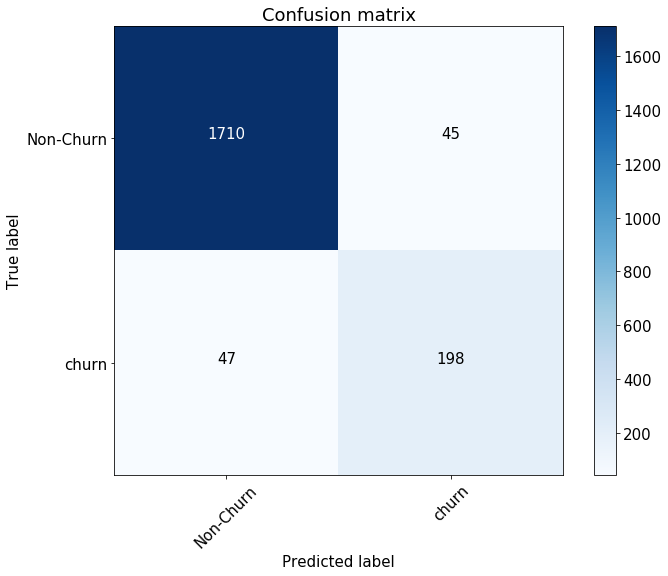

In [55]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [56]:
roc_auc_score(y_test, preds)

0.9804849119134833

In [57]:
roc_auc_max, precision_max, recall_max = roc_auc_score(y_test, preds), precision, recall
f_score_max = 2 * (precision * recall) / (precision + recall)

# 3. Сформировать на выходе единую сравнивающую таблицу качества моделей
Сравнить 3 разных метода получения эмбедингов пользователей:  
mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [59]:
def df_highlight_max(s):
    '''
    highlight the maximum
    '''
    is_max = s == s.max()
    return ['color: blue' if v else '' for v in is_max]

def df_bold_max(s):
    '''
    bold the maximum
    '''
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

metrics = ['roc_auc',
           'precision',
           'recall',
           'f_score']
metrics_types = ['mean',
                 'median',
                 'max']

models_acccuracy = pd.DataFrame(columns=metrics_types)
for col in metrics_types:
    for row in metrics:
        models_acccuracy.loc[row, col] = np.mean(eval(f'{row}_{col}'))
print('Сравнение качества получившихся данных\nпо столбцам -- метод,\nпо строкам -- метрика,\n\
цветом -- наилучшее значение\n')
models_acccuracy.style.apply(df_highlight_max, axis=1).apply(df_bold_max, axis=1)

Сравнение качества получившихся данных
по столбцам -- метод,
по строкам -- метрика,
цветом -- наилучшее значение



,mean,median,max
roc_auc,0.959981,0.979852,0.980485
precision,0.499534,0.751799,0.613995
recall,0.817705,0.693102,0.812128
f_score,0.531626,0.639631,0.604861


# 4. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Судя по результатам, идеального способа, который давал бы все хорошие метрики, -- нет.